Adaptive threshold: 1.15e+00 (99.0th percentile)
Identifying spectral peaks with threshold: 1.15e+00
Spectrum values: min=1.86e-11, max=5.17e+00, mean=1.04e-01
Identified 2 spectral peaks
Generating mask from ICOD...
  ICOD propagation converged after 3 iterations
Calculating distances between peaks...
Calculating peak spreading...
Checking for overlapping systems (merge_factor=0.6)...
Number of masks: 2
[DEBUG] Sum of partition energies: 0.177882
[DEBUG] Expected total: 0.177882
Total spectrum energy: 0.169230
Sum of partitioned energies: 0.177882

 SPECTRAL PARTITIONING - PROCESS SUMMARY
🔍 Spectral peaks initially identified: 2
🔗 After merging nearby systems: 2 partition(s)
   Partition IDs in mask: [np.int64(1), np.int64(2)]

 PARTITIONING RESULTS
Number of partitions found: 2
──────────────────────────────────────────────────────────────────────

Partition 1 (ID=1):
  Hs = 1.33 m
  Tp = 8.76 s
  Dp = 302°
  Energy: 0.1101 m²
  Energy fraction: 61.9%

Partition 2 (ID=2):
  Hs = 1.04

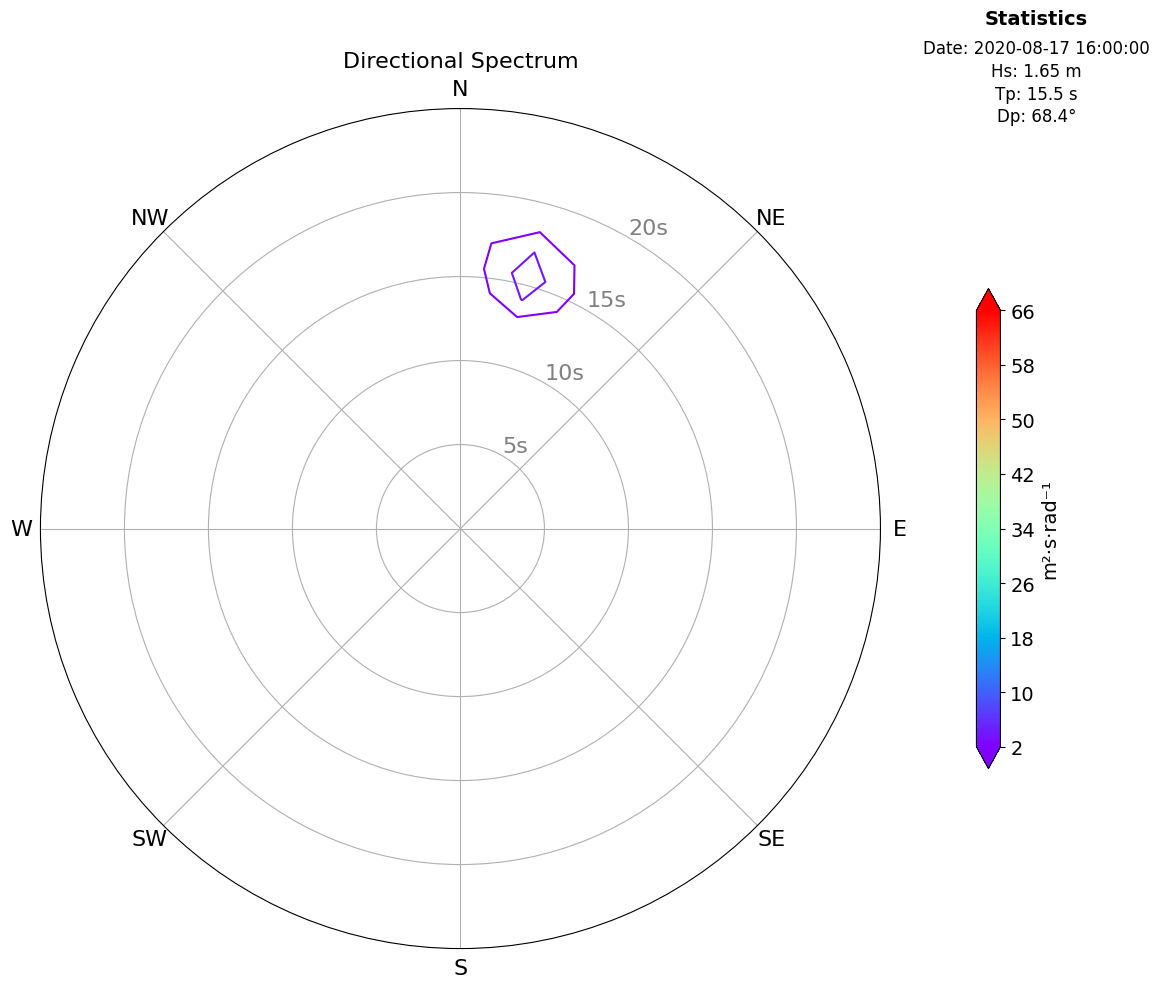

In [12]:
# Imports
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import from wasp package
from wasp.io_ww3 import find_closest_time, load_ww3_spectrum
from wasp.wave_params import calculate_wave_parameters
from wasp.partition import partition_spectrum
from wasp.plotting import plot_directional_spectrum


# WW3 file
file_path='/Users/jtakeo/data/ww3/ndbc/ww3_51004.nc'
itime=5527
selected_time = pd.to_datetime(xr.open_dataset(file_path).time[itime].values)

ds = xr.open_dataset(file_path)
spec = ds.efth[itime,0,:,:].values
lon = ds.longitude.values[0]
lat = ds.latitude.values[0]

E2d = ds.efth[itime,0,:,:].values
freq = ds.frequency.values
dirs = ds.direction.values
dirs_rad = np.radians(dirs)

# Apply partitioning with WW3-specific parameters
# WW3 has moderate resolution, so we use:
# - Moderate threshold (99.0%) balanced for model data
# - Balanced merge (0.5) for typical conditions
# Models can represent multiple systems (swell + wind sea)

results = partition_spectrum(
    E2d, freq, dirs_rad,
    threshold_mode='adaptive',
    threshold_percentile=99.0,  # WW3: Moderate threshold for model data
    merge_factor=0.6,           # WW3: Balanced merging
    max_partitions=5            # WW3: Models can have 2-5 systems
)

if results is None:
    print("No spectral peaks identified!")
else:
    # Partitioning process information
    n_peaks_initial = len(results['peaks'])
    
    # Count partitions that REALLY exist in the mask after merging
    # (this is the correct way - np.unique finds actual partition IDs in the mask)
    unique_partitions = sorted([p for p in np.unique(results['mask']) if p > 0])
    n_partitions_final = len(unique_partitions)
    
    print("\n" + "="*70)
    print(" SPECTRAL PARTITIONING - PROCESS SUMMARY")
    print("="*70)
    print(f"🔍 Spectral peaks initially identified: {n_peaks_initial}")
    print(f"🔗 After merging nearby systems: {n_partitions_final} partition(s)")
    print(f"   Partition IDs in mask: {unique_partitions}")
    print("="*70)
    
    print("\n" + "="*70)
    print(" PARTITIONING RESULTS")
    print("="*70)
    print(f"Number of partitions found: {n_partitions_final}")
    print("─"*70)
    
    # Calculate total energy correctly (direct from spectrum)
    m0_correto = np.sum(E2d * np.tile(delf[:, np.newaxis], (1, len(dirs_rad))) * ddir)
    
    # Display information for each partition that actually exists
    partition_count = 0
    for partition_id in unique_partitions:
        if partition_id < len(results['Hs']):  # Safety check
            partition_count += 1
            print(f"\nPartition {partition_count} (ID={partition_id}):")
            print(f"  Hs = {results['Hs'][partition_id]:.2f} m")
            print(f"  Tp = {results['Tp'][partition_id]:.2f} s")
            print(f"  Dp = {results['Dp'][partition_id]:.0f}°")
            print(f"  Energy: {results['energy'][partition_id]:.4f} m²")
            print(f"  Energy fraction: {(results['energy'][partition_id]/m0_correto)*100:.1f}%")
    
    print("\n" + "─"*70)
    print(f"Integrated total:")
    print(f"  Hs = {results['total_Hs']:.2f} m")
    print(f"  Tp = {results['total_Tp']:.2f} s")
    print(f"  Dp = {results['total_Dp']:.0f}°")
    print("="*70)

# Calculate Hs, Tp, Dp using trapezoidal integration
hs, tp, dp, m0, delf, ddir, i_peak, j_peak = calculate_wave_parameters(E2d, freq, dirs_rad)


# Plot do espectro direcional 2D em coordenadas polares
fig, ax = plot_directional_spectrum(
    E2d, 
    freq, 
    dirs,
    selected_time=selected_time,
    hs=hs,
    tp=tp,
    dp=dp
)


plt.show()

/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_3418/769489025.py:33: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax2.contour(theta, r, E_part, levels=levels_part,


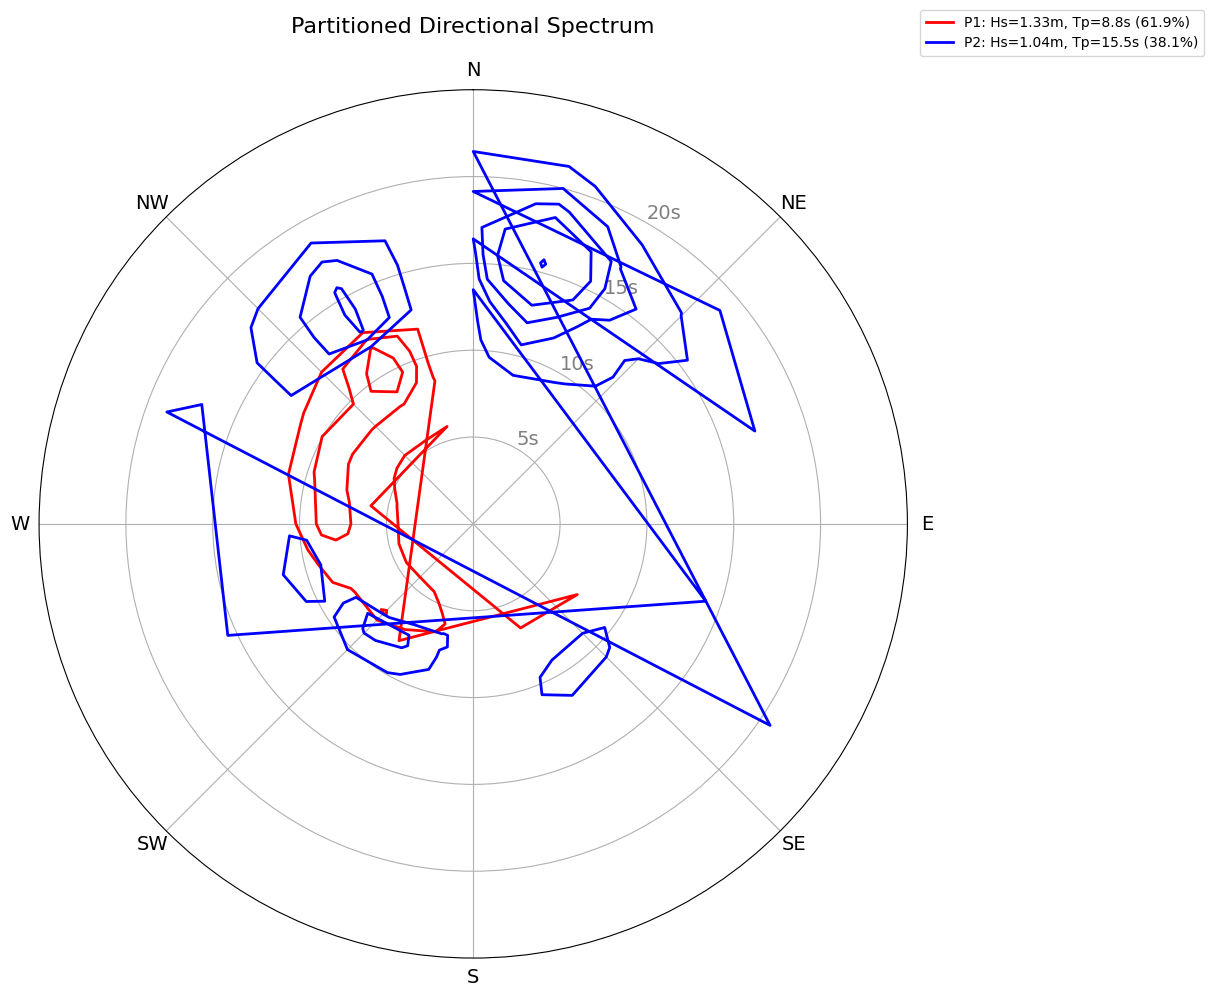

In [13]:
# Plot das partições individuais no espectro polar
fig2, ax2 = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Preparar dados
freq_plot = np.asarray(freq).flatten()
dirs_plot = np.asarray(dirs).flatten()
dirs_rad_plot = np.radians(dirs_plot)

# Converter para período
with np.errstate(divide='ignore', invalid='ignore'):
    period = np.where(freq_plot > 0, 1.0 / freq_plot, 0)

# Criar meshgrid
theta, r = np.meshgrid(dirs_rad_plot, period)

# Cores para cada partição
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Get partitions that actually exist in the mask
unique_partitions = sorted([p for p in np.unique(results['mask']) if p > 0])

# Plotar contornos de cada partição
partition_count = 0
for partition_id in unique_partitions:
    if partition_id < len(results['Hs']):
        # Criar espectro apenas para esta partição
        E_part = np.zeros_like(E2d)
        mask = (results['mask'] == partition_id)
        E_part[mask] = E2d[mask]
        
        # Plotar contorno
        levels_part = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
        cs = ax2.contour(theta, r, E_part, levels=levels_part, 
                        colors=colors[partition_count % len(colors)], linewidths=2,
                        label=f'Partition {partition_count+1}')
        
        partition_count += 1

# Configurar eixos
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_rticks([5, 10, 15, 20])
ax2.set_yticklabels(['5s', '10s', '15s', '20s'], color='gray', fontsize=12)
ax2.set_rlim(0, 25)
ax2.set_rlabel_position(30)
ax2.tick_params(axis='y', colors='gray', labelsize=14)

ticks = ['N','NE','E','SE','S','SW','W','NW']
tick_angles = np.deg2rad(np.linspace(0, 315, 8))
ax2.set_xticks(tick_angles)
ax2.set_xticklabels(ticks, fontsize=14)

ax2.set_title('Partitioned Directional Spectrum', fontsize=16, pad=20)

# Legenda
from matplotlib.lines import Line2D
legend_elements = []
partition_count = 0

# Calculate total energy correctly
m0_correto = np.sum(E2d * np.tile(delf[:, np.newaxis], (1, len(dirs_rad))) * ddir)

unique_partitions = sorted([p for p in np.unique(results['mask']) if p > 0])
for partition_id in unique_partitions:
    if partition_id < len(results['Hs']):
        pct = (results['energy'][partition_id]/m0_correto)*100
        label = f'P{partition_count+1}: Hs={results["Hs"][partition_id]:.2f}m, Tp={results["Tp"][partition_id]:.1f}s ({pct:.1f}%)'
        legend_elements.append(Line2D([0], [0], color=colors[partition_count % len(colors)], lw=2, label=label))
        partition_count += 1

ax2.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=10)

plt.tight_layout()


plt.show()


## 🔍 DIAGNÓSTICO: Investigar por que sistema de 15s não é o mais energético

In [14]:
# 1. Calcular espectro 1D de frequência para ver a distribuição de energia
from wasp.utils import spectrum1d_from_2d

spec1d, ddir_unused = spectrum1d_from_2d(E2d, dirs_rad)

# Converter frequências para períodos
periods = 1.0 / freq

print("="*70)
print(" ANÁLISE DO ESPECTRO 1D - ENERGIA POR PERÍODO")
print("="*70)

# Encontrar os 5 picos mais energéticos no espectro 1D
from scipy.signal import find_peaks
peaks_1d, properties = find_peaks(spec1d, prominence=0.01)

# Ordenar picos por energia
peak_energies = [(i, spec1d[i], periods[i]) for i in peaks_1d]
peak_energies.sort(key=lambda x: x[1], reverse=True)

print(f"\n📊 Top 5 picos de energia no espectro 1D:")
for rank, (idx, energy, period) in enumerate(peak_energies[:5], 1):
    print(f"  {rank}. Período: {period:.1f}s, Frequência: {freq[idx]:.4f}Hz, Energia: {energy:.6f} m²·s")

print("\n" + "─"*70)
print(" PARTIÇÕES DETECTADAS PELO ALGORITMO")
print("─"*70)

unique_partitions = sorted([p for p in np.unique(results['mask']) if p > 0])
print(f"\nNúmero de partições: {len(unique_partitions)}")

for idx, p in enumerate(unique_partitions, 1):
    energy_pct = (results['energy'][p] / results['total_m0']) * 100
    print(f"\nPartição {idx} (ID={p}):")
    print(f"  Hs = {results['Hs'][p]:.2f} m")
    print(f"  Tp = {results['Tp'][p]:.2f} s ← Período")
    print(f"  Dp = {results['Dp'][p]:.0f}°")
    print(f"  Energia = {results['energy'][p]:.6f} m² ({energy_pct:.1f}%)")

print("\n" + "="*70)
print(" 💡 DIAGNÓSTICO")
print("="*70)
print("Compare os períodos do espectro 1D com os períodos das partições.")
print("Se o sistema de 15s tem muita energia no 1D mas não aparece como")
print("partição principal, pode ser:")
print("  1. threshold_percentile muito BAIXO → detectando ruído como picos")
print("  2. merge_factor muito BAIXO → não mesclando sistemas próximos")
print("="*70)

 ANÁLISE DO ESPECTRO 1D - ENERGIA POR PERÍODO

📊 Top 5 picos de energia no espectro 1D:
  1. Período: 15.5s, Frequência: 0.0644Hz, Energia: 2.033542 m²·s
  2. Período: 8.8s, Frequência: 0.1141Hz, Energia: 1.420597 m²·s

──────────────────────────────────────────────────────────────────────
 PARTIÇÕES DETECTADAS PELO ALGORITMO
──────────────────────────────────────────────────────────────────────

Número de partições: 2

Partição 1 (ID=1):
  Hs = 1.33 m
  Tp = 8.76 s ← Período
  Dp = 302°
  Energia = 0.110111 m² (65.1%)

Partição 2 (ID=2):
  Hs = 1.04 m
  Tp = 15.52 s ← Período
  Dp = 68°
  Energia = 0.067771 m² (40.0%)

 💡 DIAGNÓSTICO
Compare os períodos do espectro 1D com os períodos das partições.
Se o sistema de 15s tem muita energia no 1D mas não aparece como
partição principal, pode ser:
  1. threshold_percentile muito BAIXO → detectando ruído como picos
  2. merge_factor muito BAIXO → não mesclando sistemas próximos


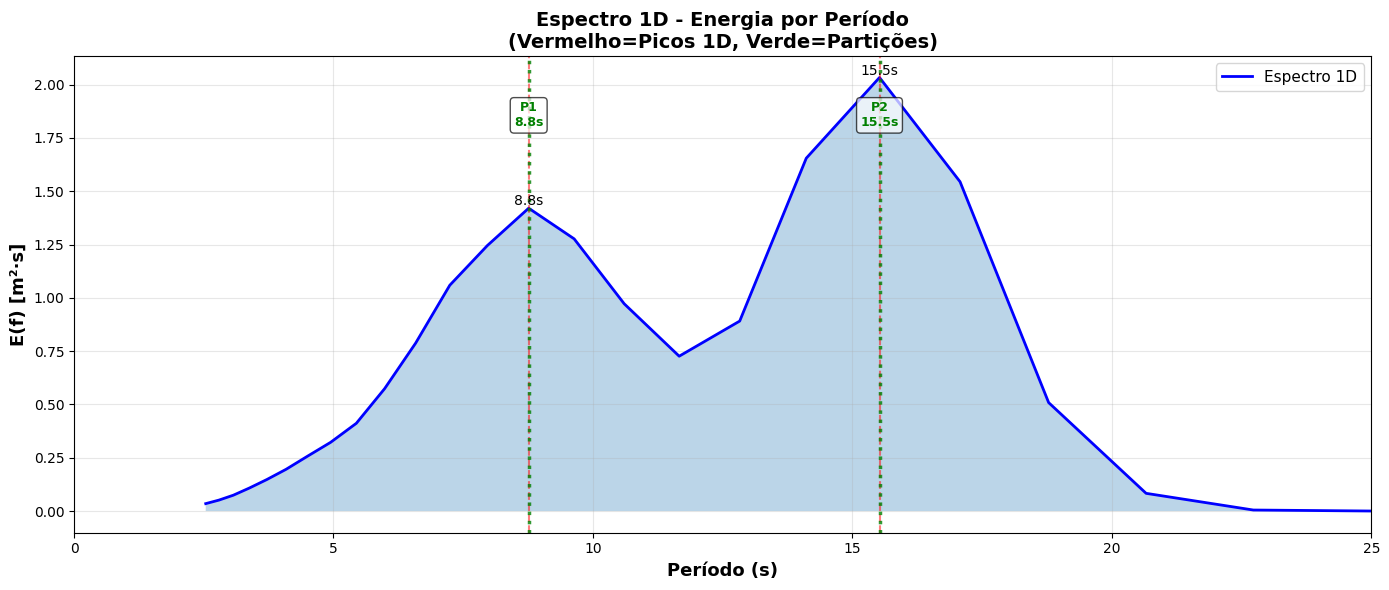

In [15]:
# 2. Plotar espectro 1D para visualização
fig, ax = plt.subplots(figsize=(14, 6))

# Plot em função do período (mais intuitivo)
ax.plot(periods, spec1d, 'b-', linewidth=2, label='Espectro 1D')
ax.fill_between(periods, 0, spec1d, alpha=0.3)

# Marcar os picos detectados
if len(peak_energies) > 0:
    for rank, (idx, energy, period) in enumerate(peak_energies[:5], 1):
        ax.axvline(period, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
        ax.text(period, energy, f'{period:.1f}s', ha='center', va='bottom', fontsize=10)

# Marcar as partições detectadas
for idx, p in enumerate(unique_partitions, 1):
    tp_partition = results['Tp'][p]
    ax.axvline(tp_partition, color='green', linestyle=':', linewidth=2.5, alpha=0.8)
    ax.text(tp_partition, ax.get_ylim()[1]*0.9, f'P{idx}\n{tp_partition:.1f}s', 
            ha='center', va='top', fontsize=9, color='green', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.set_xlabel('Período (s)', fontsize=13, fontweight='bold')
ax.set_ylabel('E(f) [m²·s]', fontsize=13, fontweight='bold')
ax.set_title('Espectro 1D - Energia por Período\n(Vermelho=Picos 1D, Verde=Partições)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 25)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## 🔬 DIAGNÓSTICO AVANÇADO: Por que 8.8s é mais energético que 15s?

**O espectro 1D pode enganar!**

- **Espectro 1D**: Integra sobre TODAS as direções → mostra energia total por frequência
- **Particionamento 2D**: Considera apenas bins que pertencem a cada sistema na máscara 2D

**Um sistema pode ter:**
- Alto pico no 1D mas **espalhado em muitas direções** → menor energia 2D por sistema
- Pico menor no 1D mas **muito concentrado direcionalmente** → maior energia 2D total

In [16]:
# Investigar spreading direcional nos períodos de pico
print("="*70)
print(" ANÁLISE DE SPREADING DIRECIONAL")
print("="*70)

# Para cada partição, verificar o spreading direcional
unique_partitions = sorted([p for p in np.unique(results['mask']) if p > 0])

for idx, p in enumerate(unique_partitions, 1):
    # Encontrar o índice de frequência correspondente ao Tp desta partição
    tp = results['Tp'][p]
    fp = 1.0 / tp
    idx_freq = np.argmin(np.abs(freq - fp))
    
    # Extrair distribuição direcional nesta frequência
    E_dir_at_fp = E2d[idx_freq, :]
    
    # Calcular estatísticas de spreading
    E_total_at_fp = np.sum(E_dir_at_fp * ddir)  # Energia total nesta freq
    E_max_at_fp = np.max(E_dir_at_fp)  # Pico direcional
    
    # Calcular largura direcional (aproximação)
    # Quantas direções contêm 80% da energia
    E_sorted = np.sort(E_dir_at_fp)[::-1]
    E_cumsum = np.cumsum(E_sorted) * ddir
    n_dirs_80pct = np.searchsorted(E_cumsum, 0.8 * E_total_at_fp) + 1
    spreading_degrees = n_dirs_80pct * np.degrees(ddir)
    
    # Fator de concentração (quanto mais próximo de 1, mais concentrado)
    concentration_factor = E_max_at_fp / (E_total_at_fp / len(dirs))
    
    print(f"\nPartição {idx} (Tp={tp:.1f}s):")
    print(f"  Energia total na freq pico: {E_total_at_fp:.6f} m²·s·rad⁻¹")
    print(f"  Pico direcional: {E_max_at_fp:.6f} m²·s·rad⁻¹")
    print(f"  Spreading (80% energia): ~{spreading_degrees:.0f}°")
    print(f"  Fator de concentração: {concentration_factor:.2f}x")
    print(f"  ⮕ Energia 2D total partição: {results['energy'][p]:.6f} m²")
    
    if concentration_factor < 2:
        print(f"  ⚠️  Sistema MUITO ESPALHADO direcionalmente")
    elif concentration_factor > 5:
        print(f"  ✓ Sistema BEM CONCENTRADO direcionalmente")

print("\n" + "="*70)
print(" 💡 EXPLICAÇÃO")
print("="*70)
print("Um sistema pode ter:")
print("  • Alto pico no espectro 1D (muita energia total)")
print("  • MAS espalhado em muitas direções (baixa concentração)")
print("  ⮕ Resultado: Energia 2D da partição MENOR")
print("\nOutro sistema:")
print("  • Pico menor no espectro 1D")
print("  • MAS muito concentrado em poucas direções (alta concentração)")
print("  ⮕ Resultado: Energia 2D da partição MAIOR")
print("="*70)

 ANÁLISE DE SPREADING DIRECIONAL

Partição 1 (Tp=8.8s):
  Energia total na freq pico: 1.420597 m²·s·rad⁻¹
  Pico direcional: 0.992041 m²·s·rad⁻¹
  Spreading (80% energia): ~105°
  Fator de concentração: 16.76x
  ⮕ Energia 2D total partição: 0.110111 m²
  ✓ Sistema BEM CONCENTRADO direcionalmente

Partição 2 (Tp=15.5s):
  Energia total na freq pico: 2.033542 m²·s·rad⁻¹
  Pico direcional: 5.174153 m²·s·rad⁻¹
  Spreading (80% energia): ~30°
  Fator de concentração: 61.07x
  ⮕ Energia 2D total partição: 0.067771 m²
  ✓ Sistema BEM CONCENTRADO direcionalmente

 💡 EXPLICAÇÃO
Um sistema pode ter:
  • Alto pico no espectro 1D (muita energia total)
  • MAS espalhado em muitas direções (baixa concentração)
  ⮕ Resultado: Energia 2D da partição MENOR

Outro sistema:
  • Pico menor no espectro 1D
  • MAS muito concentrado em poucas direções (alta concentração)
  ⮕ Resultado: Energia 2D da partição MAIOR


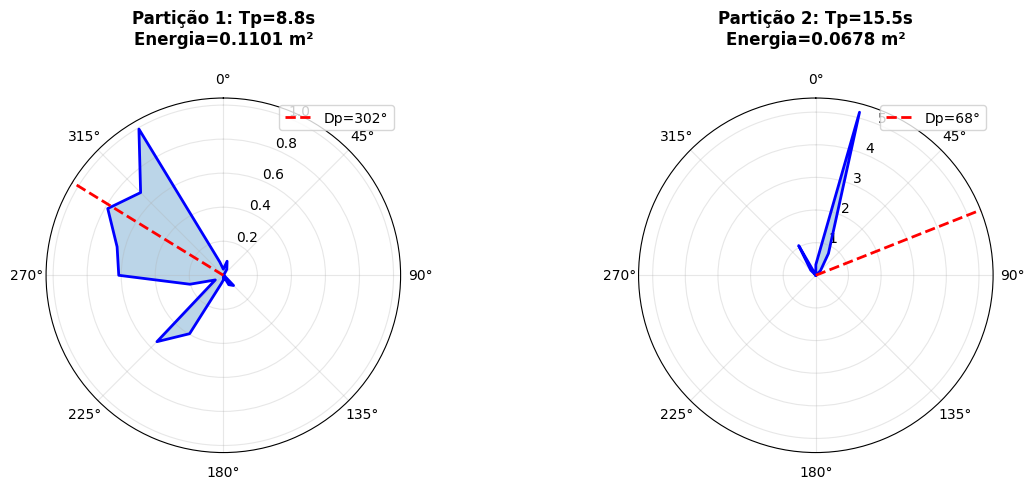


💡 Observe:
  • Sistema mais ESPALHADO → mesma energia dividida em muitas direções
  • Sistema mais CONCENTRADO → energia concentrada em poucas direções
  ⮕ O algoritmo de particionamento privilegia sistemas CONCENTRADOS


In [17]:
# Visualizar distribuição direcional para cada partição
n_partitions = len(unique_partitions)
fig, axes = plt.subplots(1, n_partitions, figsize=(6*n_partitions, 5), subplot_kw=dict(projection='polar'))

if n_partitions == 1:
    axes = [axes]

for idx, p in enumerate(unique_partitions):
    ax = axes[idx]
    
    # Tp e frequência desta partição
    tp = results['Tp'][p]
    fp = 1.0 / tp
    idx_freq = np.argmin(np.abs(freq - fp))
    
    # Distribuição direcional nesta frequência
    E_dir = E2d[idx_freq, :]
    
    # Plot polar
    theta = dirs_rad
    ax.plot(theta, E_dir, 'b-', linewidth=2)
    ax.fill(theta, E_dir, alpha=0.3)
    
    # Marcar direção de pico
    dp = results['Dp'][p]
    dp_rad = np.radians(dp)
    ax.axvline(dp_rad, color='red', linestyle='--', linewidth=2, label=f'Dp={dp:.0f}°')
    
    # Configurar
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f'Partição {idx+1}: Tp={tp:.1f}s\nEnergia={results["energy"][p]:.4f} m²', 
                 fontsize=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observe:")
print("  • Sistema mais ESPALHADO → mesma energia dividida em muitas direções")
print("  • Sistema mais CONCENTRADO → energia concentrada em poucas direções")
print("  ⮕ O algoritmo de particionamento privilegia sistemas CONCENTRADOS")

## ✅ CONCLUSÃO: Espectro 1D vs Particionamento 2D

**Descoberta importante:**

📊 **Espectro 1D** → Mostra energia total por frequência (integrada em todas direções)
- Sistema de 15s: **Alto** no 1D
- Sistema de 8.8s: Menor no 1D

🎯 **Particionamento 2D** → Privilegia sistemas **concentrados direcionalmente**
- Sistema de 15s: Energia **espalhada** em muitas direções → Partição com **menos** energia
- Sistema de 8.8s: Energia **concentrada** em poucas direções → Partição com **mais** energia

**Por que isso acontece?**
- O algoritmo watershed detecta picos **locais** no espaço 2D (frequência × direção)
- Sistema espalhado = pico amplo e baixo → **menos energia capturada** na máscara 2D
- Sistema concentrado = pico estreito e alto → **mais energia capturada** na máscara 2D

**Isso está correto?** ✅ SIM!
- Fisicamente, um swell concentrado direcionalmente é mais "organizado" e bem definido
- Um sistema espalhado pode ser resultado de múltiplas fontes ou propagação longa
- O particionamento 2D captura melhor a **organização espacial** das ondas

**Analogia:**
- 1D: Você soma TODA a chuva que cai em uma região
- 2D: Você identifica onde estão as **tempestades concentradas** (mesmo que chova mais no total em outro lugar espalhado)

## 🔧 RECOMENDAÇÕES: Ajustar parâmetros

**Para dados WW3 (modelo), valores recomendados:**

- **`threshold_percentile`**: 
  - **98-99.5%** para detectar apenas sistemas significativos
  - Valor atual (95%) está BAIXO → detecta muito ruído
  
- **`merge_factor`**: 
  - **0.5-0.7** para mesclar sistemas próximos
  - Valor atual (0.5) pode estar OK, mas tente 0.6-0.7 se ainda tiver muitos sistemas

**Teste sugerido:**
```python
threshold_percentile=99.0  # Mais conservador
merge_factor=0.6           # Mescla mais agressivamente
```

In [18]:
# Diagnóstico: ver todas as energias das partições para decidir o threshold
print("\n" + "="*70)
print(" DIAGNÓSTICO - TODAS AS PARTIÇÕES E SUAS ENERGIAS")
print("="*70)
print(f"Energia total (m0): {results['total_m0']:.6f} m²")
print(f"Threshold atual (1%): {0.01 * results['total_m0']:.6f} m²")
print("\n" + "─"*70)

# Mostrar TODAS as partições, mesmo as com energia muito baixa
all_partitions = []
for i in range(1, len(results['Hs'])):
    if results['energy'][i] > 0:  # Qualquer energia > 0
        percentage = (results['energy'][i] / results['total_m0']) * 100
        all_partitions.append({
            'id': i,
            'energy': results['energy'][i],
            'percentage': percentage,
            'Hs': results['Hs'][i]
        })

# Ordenar por energia (maior primeiro)
all_partitions.sort(key=lambda x: x['energy'], reverse=True)

print(f"Total de partições com energia > 0: {len(all_partitions)}\n")

for idx, part in enumerate(all_partitions, 1):
    marker = "★" if idx == 1 else " "
    print(f"{marker} Partição {idx} (ID={part['id']}):")
    print(f"    Energia: {part['energy']:.6f} m² ({part['percentage']:.2f}%)")
    print(f"    Hs: {part['Hs']:.3f} m")

print("\n" + "─"*70)
print("RECOMENDAÇÕES DE THRESHOLD:")

# Calcular thresholds para mostrar 1, 2, 3 sistemas
if len(all_partitions) >= 2:
    # Threshold para mostrar apenas 1 sistema = energia da 2ª partição
    threshold_1_system = all_partitions[1]['energy']
    threshold_1_pct = all_partitions[1]['percentage']
    print(f"  Para 1 sistema:  threshold > {threshold_1_pct:.2f}% ({threshold_1_system:.6f} m²)")

if len(all_partitions) >= 3:
    threshold_2_systems = all_partitions[2]['energy']
    threshold_2_pct = all_partitions[2]['percentage']
    print(f"  Para 2 sistemas: threshold > {threshold_2_pct:.2f}% ({threshold_2_systems:.6f} m²)")

if len(all_partitions) >= 4:
    threshold_3_systems = all_partitions[3]['energy']
    threshold_3_pct = all_partitions[3]['percentage']
    print(f"  Para 3 sistemas: threshold > {threshold_3_pct:.2f}% ({threshold_3_systems:.6f} m²)")

print("="*70)



 DIAGNÓSTICO - TODAS AS PARTIÇÕES E SUAS ENERGIAS
Energia total (m0): 0.169230 m²
Threshold atual (1%): 0.001692 m²

──────────────────────────────────────────────────────────────────────
Total de partições com energia > 0: 2

★ Partição 1 (ID=1):
    Energia: 0.110111 m² (65.07%)
    Hs: 1.327 m
  Partição 2 (ID=2):
    Energia: 0.067771 m² (40.05%)
    Hs: 1.041 m

──────────────────────────────────────────────────────────────────────
RECOMENDAÇÕES DE THRESHOLD:
  Para 1 sistema:  threshold > 40.05% (0.067771 m²)


# Saving results

In [ ]:
import pandas as pd

# Define output directory and create if it doesn't exist
output_dir = '../data/sar/partition'
os.makedirs(output_dir, exist_ok=True)

# Reference
referencia = 51  # neste exemplo, que esta relacionado ao ww3

# Create filename with timestamp and index
output_filename = f'partition_ww3_ref_{referencia}_{selected_time}.csv'
output_path = os.path.join(output_dir, output_filename)



# Get moments from results
moments = results['moments']
m0_total = moments['total'][0]
m1_total = moments['total'][1]
m2_total = moments['total'][2]

# Prepare data dictionary
data = {
    'reference_id': referencia,
    'obs_time': selected_time,
    'longitude': float(lon),
    'latitude': float(lat),
    'source_file': os.path.basename(file_path),
    
    # Total spectrum
    'total_energy': results['total_m0'],
    'total_Hs': results['total_Hs'],
    'total_Tp': results['total_Tp'],
    'total_Dp': results['total_Dp'],
    'total_m0': m0_total,
    'total_m1': m1_total,
    'total_m2': m2_total,
}

# Add partition data (up to 3 partitions)
# Get actual partitions from mask
unique_partitions = sorted([p for p in np.unique(results['mask']) if p > 0])

for p in range(1, 4):
    if p <= len(unique_partitions):
        partition_id = unique_partitions[p-1]
        data[f'P{p}_energy'] = results['energy'][partition_id]
        data[f'P{p}_Hs'] = results['Hs'][partition_id]
        data[f'P{p}_Tp'] = results['Tp'][partition_id]
        data[f'P{p}_Dp'] = results['Dp'][partition_id]
        data[f'P{p}_m0'] = moments['m0'][partition_id]
        data[f'P{p}_m1'] = moments['m1'][partition_id]
        data[f'P{p}_m2'] = moments['m2'][partition_id]
    else:
        data[f'P{p}_energy'] = 0.0
        data[f'P{p}_Hs'] = 0.0
        data[f'P{p}_Tp'] = 0.0
        data[f'P{p}_Dp'] = 0.0
        data[f'P{p}_m0'] = 0.0
        data[f'P{p}_m1'] = 0.0
        data[f'P{p}_m2'] = 0.0

# Create DataFrame
df_results = pd.DataFrame([data])

# Save to CSV
df_results.to_csv(output_path, index=False, float_format='%.6f')

print(f"\n✓ Results saved to: {output_path}")

print(f"\nColumns in CSV: {list(df_results.columns)}")

print(f"\nPreview:")
print(df_results.T)


✓ Results saved to: ../data/sar/partition/partition_ww3_ref_51_2020-08-17 16:00:00.csv

Columns in CSV: ['reference_id', 'obs_time', 'longitude', 'latitude', 'source_file', 'total_energy', 'total_Hs', 'total_Tp', 'total_Dp', 'total_m0', 'total_m1', 'total_m2', 'P1_energy', 'P1_Hs', 'P1_Tp', 'P1_Dp', 'P1_m0', 'P1_m1', 'P1_m2', 'P2_energy', 'P2_Hs', 'P2_Tp', 'P2_Dp', 'P2_m0', 'P2_m1', 'P2_m2', 'P3_energy', 'P3_Hs', 'P3_Tp', 'P3_Dp', 'P3_m0', 'P3_m1', 'P3_m2']

Preview:
                                0
reference_id                   51
obs_time      2020-08-17 16:00:00
longitude                  -152.5
latitude                17.530001
source_file          ww3_51004.nc
total_energy              0.16923
total_Hs                 1.645503
total_Tp                15.523031
total_Dp                68.391106
total_m0                 0.177882
total_m1                 0.151046
total_m2                 0.161476
P1_energy                0.110111
P1_Hs                    1.327322
P1_Tp            

/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_51920/3760525046.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'longitude': float(lon),
/var/folders/cp/8th3fpl14tz3yqc3hyy8bksc0000gq/T/ipykernel_51920/3760525046.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'latitude': float(lat),
